# Custom Example House Engery

[Using foundation models for time series forecasting](https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/)

In [2]:
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

## Step1. Import the libraries

In [3]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

## Step 2. Load the data

In [4]:
energy_data_df = pd.read_json(
    "/Users/thomassuedbroecker/Documents/tsuedbro/dev/granite-tsfm/notebooks/example/time-series.json"
)
energy_data_df.head(3)

,power,voltage,date
0,-67.69,227.44,2024-04-16 13:19:06
1,97.16,226.30,2024-04-25 06:27:59
2,67.95,225.70,2024-02-03 13:38:12


In [5]:
energy_data_sorted_df = energy_data_df.sort_values('date',ascending = True)
#energy_data_df['date_new'] = pd.to_datetime(energy_data_df['date'])
#energy_data_df.sort_values(by=['date_new'],ascending = True)
energy_data_sorted_df.head(20)

,power,voltage,date
7594,329.80,222.41,2023-12-25 15:20:15
7252,337.36,222.25,2023-12-25 15:27:13
7595,1554.92,225.60,2023-12-25 16:09:04
18689,89.22,226.14,2024-01-03 10:43:08
18688,217.73,226.39,2024-01-04 08:36:08
5897,88.82,223.52,2024-01-04 19:39:28
7744,248.53,226.89,2024-01-05 19:01:13
13493,152.44,227.81,2024-01-05 21:40:33
18385,152.44,227.81,2024-01-05 21:40:33
7745,415.77,227.60,2024-01-05 21:49:20


## Step 3. Add date column

In [6]:
energy_data_sorted_df['power'] = energy_data_sorted_df['power'].interpolate()
energy_data_sorted_df['power'].head(3)

7594     329.80
7252     337.36
7595    1554.92
Name: power, dtype: float64

<Axes: xlabel='date'>

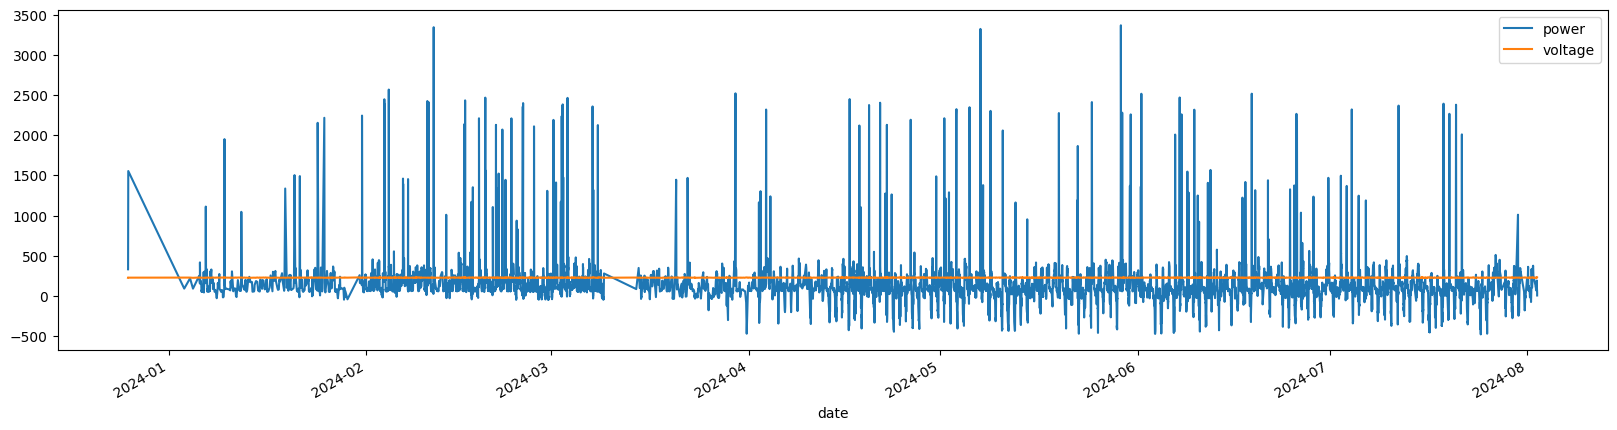

In [7]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
energy_data_sorted_df[:20000].plot(x="date", y=["power", "voltage"], figsize=(20,5))

## Step 4: Prepare the data

In [8]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Results dir
OUT_DIR = "/Users/thomassuedbroecker/Documents/tsuedbro/dev/granite-tsfm/notebooks/example/ttm_finetuned_energy_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"


# Forecasting parameters
id_columns = []
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future
fewshot_fraction = 0.05

In [9]:
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

data_length = len(energy_data_sorted_df)

train_start_index = 0
train_end_index = round(data_length * 0.8)
print(f"data_length:\n{data_length}\ntrain_start_index:\n{train_start_index}\ntrain_end_index\n{train_end_index}")

data_length:
22864
train_start_index:
0
train_end_index
18291


In [10]:
# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
eval_start_index = round(data_length * 0.8) - context_length
eval_end_index = round(data_length * 0.9)
print(f"eval_start_index:\n{eval_start_index}\neval_end_index:\n{eval_end_index}\n")

eval_start_index:
17779
eval_end_index:
20578



In [11]:
test_start_index = round(data_length * 0.9) - context_length
test_end_index = data_length
print(f"test_start_index:\n{test_start_index}\ntest_end_index:\n{test_end_index}\n")

test_start_index:
20066
test_end_index:
22864



In [12]:
split_config = {
                "train": [0, train_end_index],
                "valid": [eval_start_index, eval_end_index],
                "test": [test_start_index,test_end_index],
            }

In [13]:
timestamp_column = 'date'
target_columns = ['power']
#observable_columns = ['power']
observable_columns = ['voltage']

column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    #id_columns=[], # not use here because you need to train on this columns
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

# this gets torch vectors for training. For test eval we need a Pandas DF
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, energy_data_sorted_df, split_config
)

In [14]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)  #note that this is the Torch dataset created by get_datasets(), not a Pandas DataFrame

{'eval_loss': 1.0046800374984741,
 'eval_model_preparation_time': 0.0007,
 'eval_runtime': 4.6839,
 'eval_samples_per_second': 577.083,
 'eval_steps_per_second': 72.162}

## Step 5. Use the TTM model for forecasting

In [15]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

zs_forecast_pipeline = TimeSeriesForecastingPipeline(
    model=zeroshot_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    freq="1h"
)

In [16]:
zs_forecast = zs_forecast_pipeline(tsp.preprocess(energy_data_sorted_df[test_start_index:test_end_index]))

In [17]:
zs_forecast.head(3)

,date,power_prediction,power
0,2024-08-17 06:14:48,"[-0.1531282663345337, -0.18255837261676788, -0...","[-0.18909095227718353, -0.1989595592021942, -0..."
1,2024-08-17 07:14:47,"[-0.2001805156469345, -0.22608740627765656, -0...","[-0.1989595592021942, -0.19936373829841614, -0..."
2,2024-08-17 07:14:49,"[-0.23062677681446075, -0.24204814434051514, -...","[-0.19936373829841614, -0.14085939526557922, -..."


<Axes: >

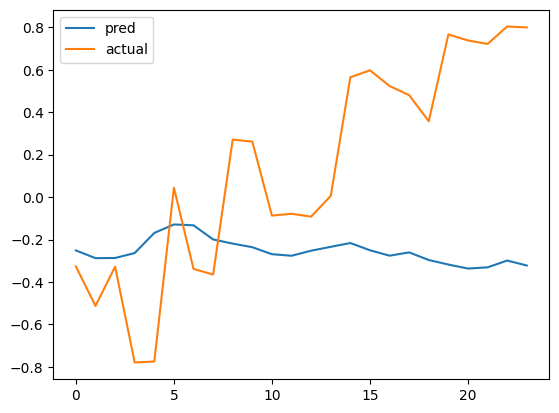

In [18]:
fcast_df = pd.DataFrame({"pred":zs_forecast.loc[50]['power_prediction'], "actual":zs_forecast.loc[50]['power'][:24]})
fcast_df.plot()

## Step 6. Evaluating the forecast results

In [19]:
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

<Axes: title={'center': '0.9813521540'}, xlabel='date'>

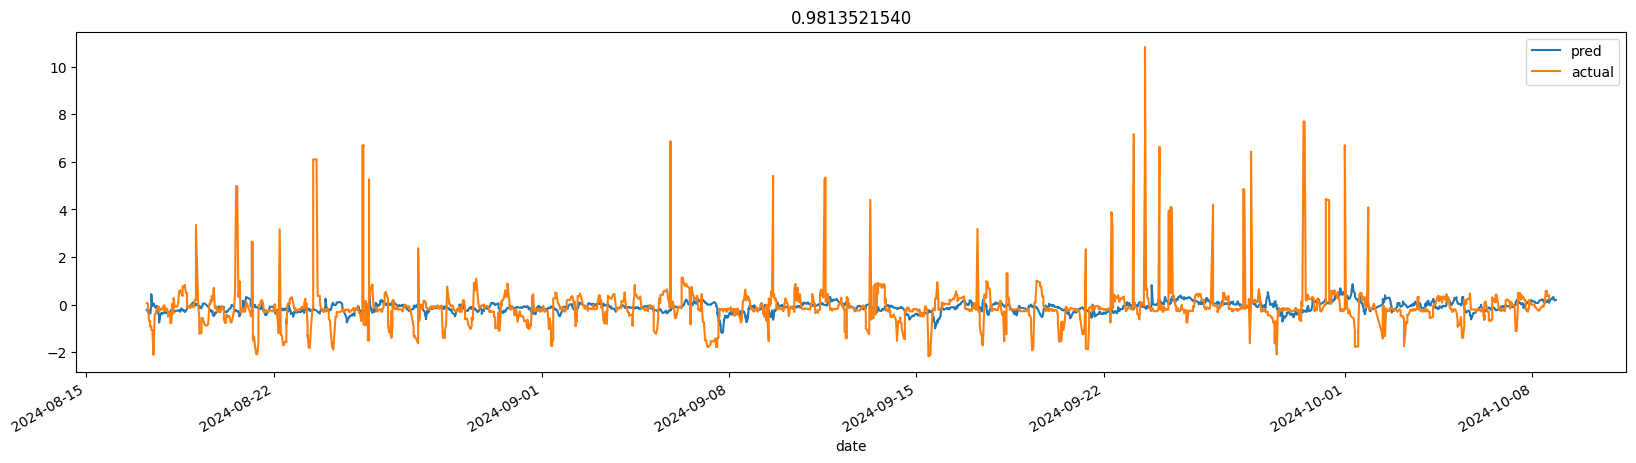

In [20]:
out_predictions = compare_forecast(zs_forecast, "date", "power_prediction", "power", 12)

out = out_predictions[[not np.isnan(x).any() for x in out_predictions['actual']]]

rms = '{:.10f}'.format(root_mean_squared_error(out['actual'], out['pred']))
out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title=str(rms))

## Step 9. Fine tuning the TTM model

In [21]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=24
)

In [22]:
# Important parameters
learning_rate = 0.001
num_epochs = 10 #20
batch_size = 32

finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    #metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

In [23]:
# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

In [24]:
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

In [25]:
finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

INFO:p-82545:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-82554:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-82606:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-82634:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-82641:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-82698:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-82699:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-82710:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.


Epoch,Training Loss,Validation Loss
1,0.887300,0.870980
2,0.841500,0.870683
3,0.797700,0.882815


INFO:p-84080:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84121:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84132:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84173:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84176:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84221:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84265:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84276:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84884:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84896:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84914:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84955:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-84974:t-8226066240:config.py:<module>:PyTorch version 2.4

[TrackingCallback] Mean Epoch Time = 90.22295800844829 seconds, Total Train Time = 443.17274284362793


TrainOutput(global_step=1659, training_loss=0.8421667097849326, metrics={'train_runtime': 443.1744, 'train_samples_per_second': 399.03, 'train_steps_per_second': 12.478, 'total_flos': 262482214256640.0, 'train_loss': 0.8421667097849326, 'epoch': 3.0})

## Step 10. Evaluating the fine-tuned TTM model

In [26]:
finetune_forecast_trainer.evaluate(test_dataset) #note that this is the torch dataset, not a Pandas DataFrame

INFO:p-88768:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-88783:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-88786:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-88843:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-88874:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-88878:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-88927:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-88938:t-8226066240:config.py:<module>:PyTorch version 2.4.1 available.


{'eval_loss': 0.9967208504676819,
 'eval_runtime': 57.3942,
 'eval_samples_per_second': 47.095,
 'eval_steps_per_second': 1.481,
 'epoch': 3.0}

In [33]:
test_dataset[1]

{'past_values': tensor([[-0.6852, -1.3510],
         [-0.6867, -1.3668],
         [-0.6867, -1.3668],
         ...,
         [-0.6082,  2.3591],
         [-0.6108,  0.0808],
         [-0.3014, -0.2593]]),
 'future_values': tensor([[-3.1674e-01, -6.9456e-02],
         [-3.3412e-01, -6.1545e-02],
         [-1.7700e-01, -1.1216e+00],
         [-1.6151e-01, -1.1295e+00],
         [-3.0357e-01, -5.8365e-01],
         [-3.0149e-01, -5.9948e-01],
         [-2.5561e-01, -1.0425e+00],
         [-2.5716e-01, -1.1928e+00],
         [-2.5969e-01, -1.1374e+00],
         [-1.9633e-01, -1.7307e+00],
         [-1.9943e-01, -1.6516e+00],
         [-1.4244e-01, -1.2719e+00],
         [-9.2156e-02, -8.4471e-01],
         [-8.8249e-02, -8.6053e-01],
         [-2.6538e-01, -4.4126e-01],
         [-1.9283e-01, -1.3274e-01],
         [-1.0927e-01, -7.7366e-02],
         [-1.0240e-01, -2.0394e-01],
         [-2.7141e-01, -5.3634e-02],
         [-1.8182e-01, -2.8305e-01],
         [-1.4446e-01, -7.0232e-01],
 

In [34]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

In [35]:
test_data = tsp.preprocess(energy_data_sorted_df[test_start_index:test_end_index])

<Axes: >

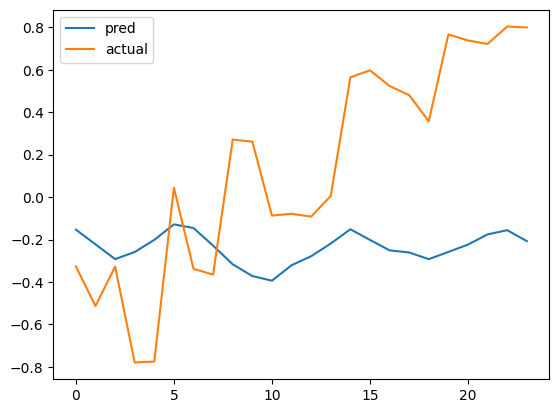

In [36]:
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)

forecasts = forecast_pipeline(test_data)

fcast_df = pd.DataFrame({"pred":forecasts.loc[50]['power_prediction'], "actual":forecasts.loc[50]['power'][:24]})
fcast_df.plot()

<Axes: title={'center': '0.9813521540'}, xlabel='date'>

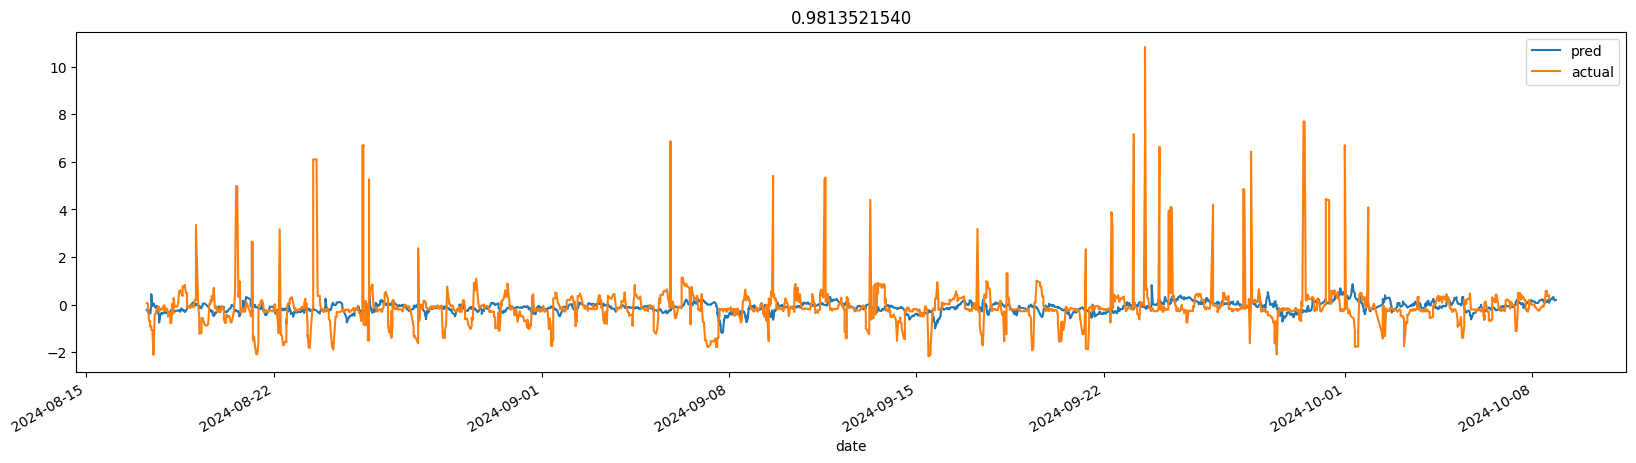

In [37]:
from sklearn.metrics import mean_squared_error

out_predictions = compare_forecast(zs_forecast, "date", "power_prediction", "power", 12)

out = out_predictions[[not np.isnan(x).any() for x in out_predictions['actual']]]

rms = '{:.10f}'.format(root_mean_squared_error(out['actual'], out['pred']))
out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title=str(rms))

<Axes: title={'center': '0.9813521540'}, xlabel='date'>

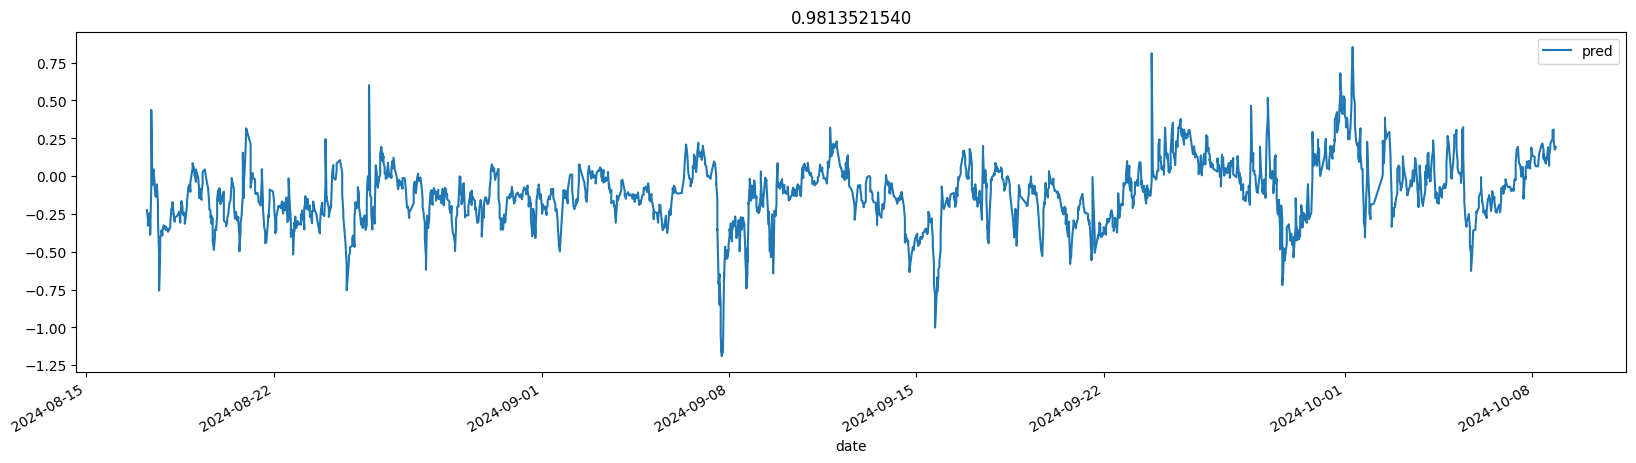

In [38]:
out_predictions.plot(x="date", y=["pred"], figsize=(20,5), title=str(rms))

<Axes: title={'center': '0.9813521540'}, xlabel='date'>

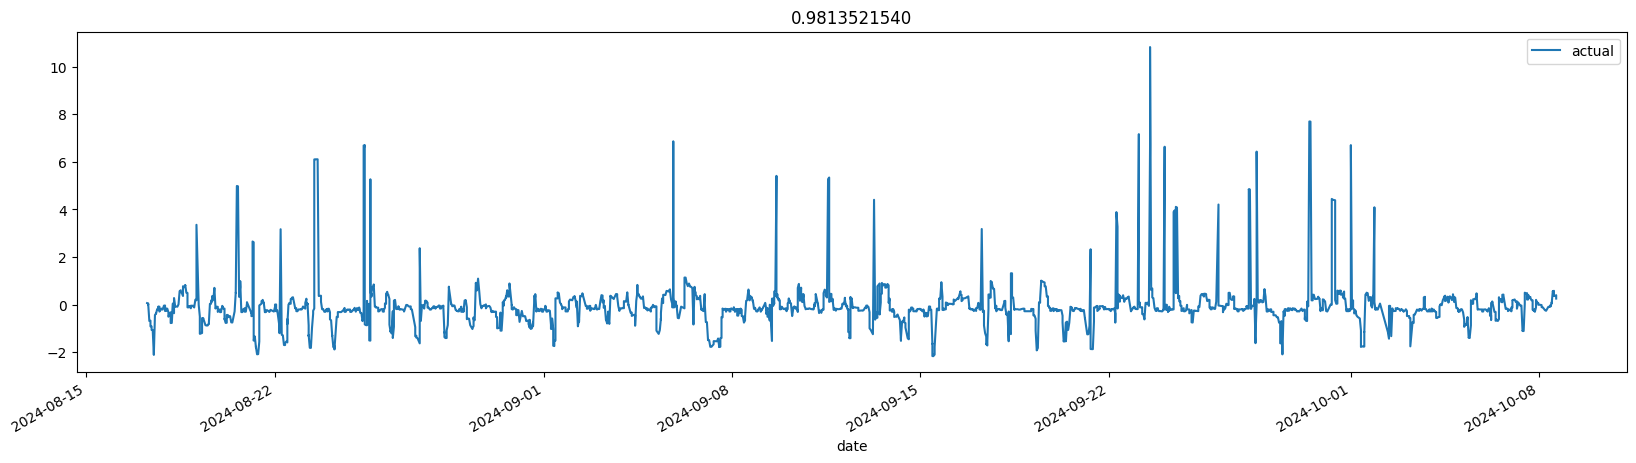

In [39]:
out_predictions.plot(x="date", y=["actual"], figsize=(20,5), title=str(rms))